# Exploratory Data Analysis (EDA) Summary

This notebook explores data quality, feature relationships, and potential predictors of the binary target.  
The analysis provides an overview of **missing values**, **feature correlations**, and **importance rankings** from different statistical and model-based methods.

---

### Missingness per Feature
- Most features show **4–6% missing values**, which is relatively mild but non-uniform across columns.  
- The missingness pattern appears **evenly distributed** across regions (US, EU, WORLD, JPN, etc.), suggesting no region-specific bias.  
- This level of missingness justifies using **simple imputation** (e.g., median or KNN) without heavy data loss.

---

### Feature Correlation Heatmap
- Strong **intra-group correlations** exist — for example, within *Momentum* and *Volatility (GARCH)* features of the same region.  
- Cross-region correlations (e.g., between US and EU momentum) are also visible, implying **shared global market dynamics**.  
- However, some features remain relatively independent (e.g., `US_Credit_Spread`, `Gold_FP_logit`), which may add unique predictive signal.

---

### Correlation with Target (Pearson)
- Positive correlations (e.g., `WORLD_returns`, `WORLD_Momentum_20`, `US_Momentum_20`) suggest that higher global and US momentum are linked with a higher probability of the positive class.  
- Negative correlations (e.g., `US_Credit_Spread`, `US_stock_implied_vol`, `WORLD_GARCH_vol`) imply that rising volatility and widening credit spreads correspond to negative outcomes.  
- Overall, momentum and returns are **pro-growth indicators**, while volatility and spreads are **risk indicators**.

---

### Mutual Information with Target
- The top features by **mutual information** are `US_3M_yield`, `EU_3M_yield`, `JPN_PE`, and `EU_PE`.  
- These capture **nonlinear dependencies** that Pearson correlation might miss — especially yield-related effects, which may reflect **macro-driven signals** rather than short-term movements.

---

### Random Forest Feature Importance
- Model-based ranking highlights `WORLD_returns`, `WORLD_Momentum_20`, and `US_Momentum_20` as dominant predictors.  
- Consistent with earlier findings, **global and US momentum/returns** are the most impactful drivers of the target.  
- Secondary importance of `US_Credit_Spread`, `US_3M_yield`, and `EU_Momentum_20` shows that **macroeconomic stress and cross-region signals** also contribute meaningfully.

---

### Takeaways
- Data is clean enough for robust modeling after imputation.  
- Predictive signal mainly comes from **momentum**, **returns**, and **interest rate–related** variables.  
- Strong feature correlations suggest **redundancy among similar indicators** — feature selection or regularization may help avoid overfitting.  
- Both correlation-based and model-based importance methods agree broadly on the same top predictors.

---


In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util_io import load_frames


In [2]:
X_train, y_train, X_test = load_frames("../data")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

display(X_train.head())
display(y_train.head())

X_train shape: (4840, 33)
y_train shape: (4840,)
X_test shape: (1566, 33)


,WORLD_Momentum_20,WORLD_Momentum_100,WORLD_GARCH_vol,WORLD_returns,JPN_Momentum_20,JPN_Momentum_100,JPN_GARCH_vol,JPN_returns,EU_Momentum_20,EU_Momentum_100,...,EU_3M_yield,US_3M_yield,US_bonds_implied_vol,US_stock_implied_vol,EU_stock_implied_vol,JPN_stock_implied_vol,US_Credit_Spread,EU_PE,US_PE,JPN_PE
0,-0.074364,0.777154,-0.474432,-0.457500,-0.417692,0.428600,-0.377776,-0.729342,-0.513785,0.373341,...,-0.681654,-0.321668,-1.043121,-0.745760,-0.663180,-0.655731,-0.292230,-0.332911,-0.331616,NaN
1,0.784460,1.920262,-0.221076,0.531731,0.530752,1.833384,-0.425562,-0.179157,1.039633,NaN,...,-1.992650,-1.701915,0.194130,0.116367,0.269311,0.113345,0.180746,3.789226,1.300890,3.358209
2,0.138199,-2.539866,1.963193,-2.407922,-1.381541,-1.837236,0.801879,-1.019399,NaN,-1.433499,...,-1.005319,0.854219,0.251248,1.565867,1.193318,0.128075,1.134201,-0.155882,0.540794,-0.817885
3,0.360038,0.191266,-0.697094,0.069112,-0.477791,-0.645935,-1.174665,0.568717,0.123803,0.384754,...,2.978832,1.343069,-1.484320,-0.451796,-0.122709,NaN,-0.993387,-0.306903,-0.756300,-0.528689
4,0.917544,0.539334,-0.720599,0.186275,1.187300,1.003747,-1.143755,-0.190646,0.080462,0.162276,...,0.270081,3.331386,-1.666469,-1.321441,-1.137686,-1.398444,-1.053625,-0.040242,-1.010903,-0.663381


0    0
1    1
2    0
3    1
4    1
Name: Target, dtype: int8

In [3]:
# class imbalance check

class_counts = y_train.value_counts()
#print(class_counts)
class_ratio = y_train.value_counts(normalize=True)
#print(class_ratio)

print("Class counts:")
display(class_counts)
print("\nClass ratio:")
display(class_ratio)

Class counts:


Target
1    3193
0    1647
Name: count, dtype: int64


Class ratio:


Target
1    0.659711
0    0.340289
Name: proportion, dtype: float64

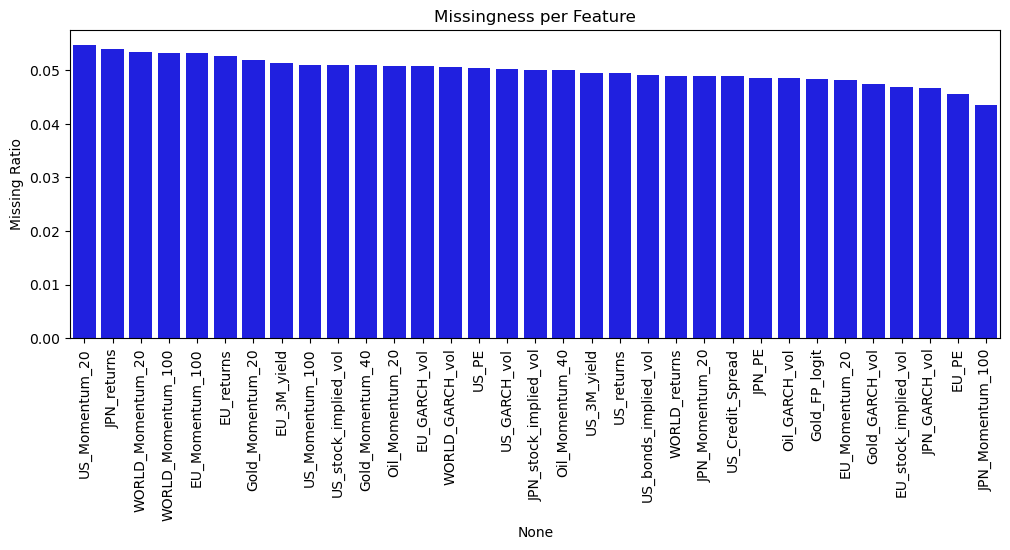

In [4]:
# missing values check

missing_pct = X_train.isna().mean().sort_values(ascending=False)

plt.figure(figsize=(12,4))
sns.barplot(x=missing_pct.index, y=missing_pct.values, color="blue")
plt.xticks(rotation=90)
plt.ylabel("Missing Ratio")
plt.title("Missingness per Feature")
plt.show()

In [5]:
# summary statistics

summary = X_train.describe().T
summary["missing_pct"] = X_train.isna().mean() * 100
summary["skew"] = X_train.skew()
summary["kurt"] = X_train.kurt()
summary.head(10)


,count,mean,std,min,25%,50%,75%,max,missing_pct,skew,kurt
WORLD_Momentum_20,4581.0,-0.004532,1.058687,-9.132739,-0.454056,0.159404,0.573487,4.849933,5.351240,-1.742871,9.235793
WORLD_Momentum_100,4582.0,-0.016673,1.214875,-8.186357,-0.405788,0.164870,0.674404,3.062027,5.330579,-1.877711,6.790738
WORLD_GARCH_vol,4595.0,0.085811,2.078489,-1.280018,-0.634196,-0.425307,-0.031181,32.457519,5.061983,7.068085,66.468529
WORLD_returns,4603.0,-0.003596,1.056059,-9.744286,-0.437460,0.040653,0.485407,11.027608,4.896694,-0.448659,12.846992
JPN_Momentum_20,4603.0,0.007727,0.974165,-7.533490,-0.553281,0.052687,0.629264,3.733031,4.896694,-0.751862,3.953750
JPN_Momentum_100,4629.0,0.009882,1.005354,-5.567102,-0.600674,0.025279,0.668525,3.336159,4.359504,-0.409975,1.865545
JPN_GARCH_vol,4614.0,-0.037934,1.833418,-1.671463,-0.706743,-0.400348,0.014506,27.211891,4.669421,6.748811,59.980021
JPN_returns,4579.0,0.001299,0.991653,-7.904605,-0.518726,0.017284,0.547715,7.717157,5.392562,-0.367618,5.033914
EU_Momentum_20,4607.0,-0.004260,1.058091,-9.010006,-0.508901,0.094878,0.633028,5.089267,4.814050,-1.389516,7.175534
EU_Momentum_100,4582.0,0.030151,1.184926,-7.675082,-0.464523,0.161536,0.684182,3.003089,5.330579,-1.615494,6.051553


In [6]:
skewed = summary["skew"].sort_values(ascending=False)
print("Most positively skewed features:")
display(skewed.head(10))
print("Most negatively skewed features:")
display(skewed.tail(10))

Most positively skewed features:


EU_PE                    67.853897
JPN_PE                   10.575740
EU_GARCH_vol              8.130632
WORLD_GARCH_vol           7.068085
JPN_GARCH_vol             6.748811
US_GARCH_vol              5.733514
Oil_GARCH_vol             5.317961
Gold_FP_logit             4.290196
Gold_GARCH_vol            4.085294
JPN_stock_implied_vol     2.851753
Name: skew, dtype: float64

Most negatively skewed features:


WORLD_returns        -0.448659
Oil_Momentum_20      -0.640154
JPN_Momentum_20      -0.751862
Oil_Momentum_40      -1.199451
EU_Momentum_20       -1.389516
US_Momentum_20       -1.560009
EU_Momentum_100      -1.615494
US_Momentum_100      -1.726633
WORLD_Momentum_20    -1.742871
WORLD_Momentum_100   -1.877711
Name: skew, dtype: float64

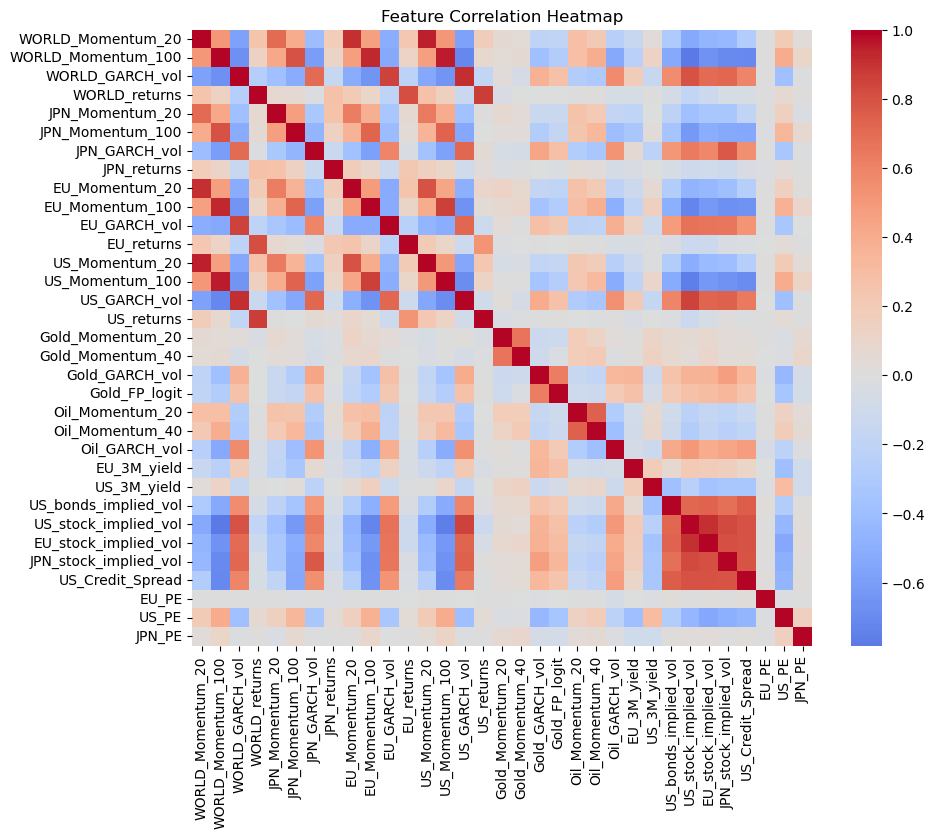

Top correlated feature pairs:


WORLD_Momentum_100    US_Momentum_100          0.956033
WORLD_Momentum_20     US_Momentum_20           0.947979
WORLD_Momentum_100    EU_Momentum_100          0.936506
WORLD_GARCH_vol       US_GARCH_vol             0.911909
WORLD_Momentum_20     EU_Momentum_20           0.908955
US_stock_implied_vol  EU_stock_implied_vol     0.903132
WORLD_returns         US_returns               0.872741
EU_Momentum_100       US_Momentum_100          0.865012
WORLD_GARCH_vol       EU_GARCH_vol             0.846906
US_GARCH_vol          US_stock_implied_vol     0.846859
US_stock_implied_vol  JPN_stock_implied_vol    0.830928
WORLD_returns         EU_returns               0.816916
EU_stock_implied_vol  JPN_stock_implied_vol    0.811722
US_stock_implied_vol  US_Credit_Spread         0.804169
WORLD_GARCH_vol       US_stock_implied_vol     0.802476
dtype: float64

In [7]:
corr = X_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# Top correlated pairs
tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
top_corr_pairs = tri.stack().sort_values(ascending=False).head(15)
print("Top correlated feature pairs:")
top_corr_pairs

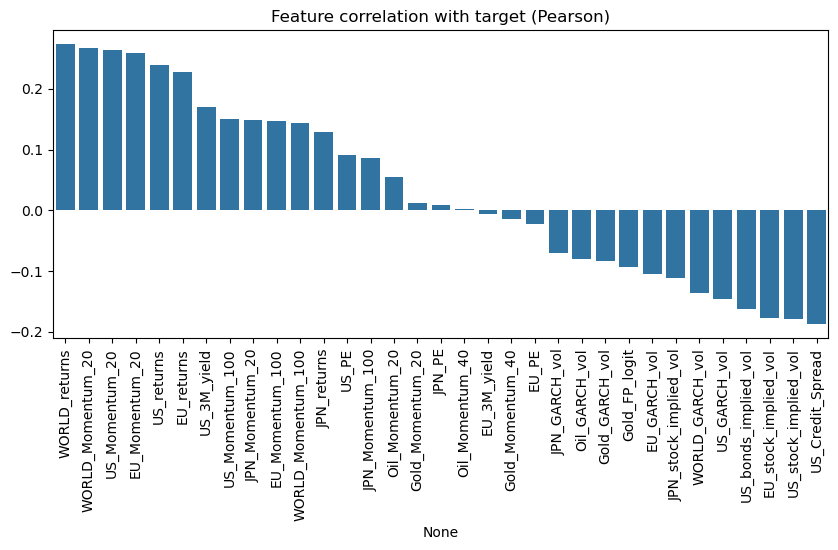

In [8]:
corr_with_target = X_train.apply(
    lambda col: np.corrcoef(col.fillna(col.median()), y_train)[0, 1]
)
corr_with_target = corr_with_target.sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.xticks(rotation=90)
plt.title("Feature correlation with target (Pearson)")
plt.show()


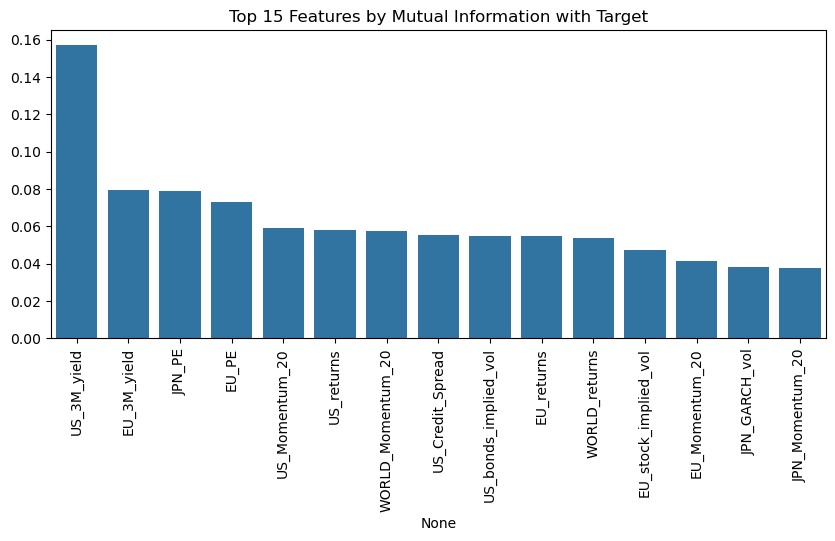

In [9]:
from sklearn.feature_selection import mutual_info_classif

X_mi = X_train.fillna(X_train.median())
mi = mutual_info_classif(X_mi, y_train, random_state=42)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(x=mi_series.index[:15], y=mi_series.values[:15])
plt.xticks(rotation=90)
plt.title("Top 15 Features by Mutual Information with Target")
plt.show()

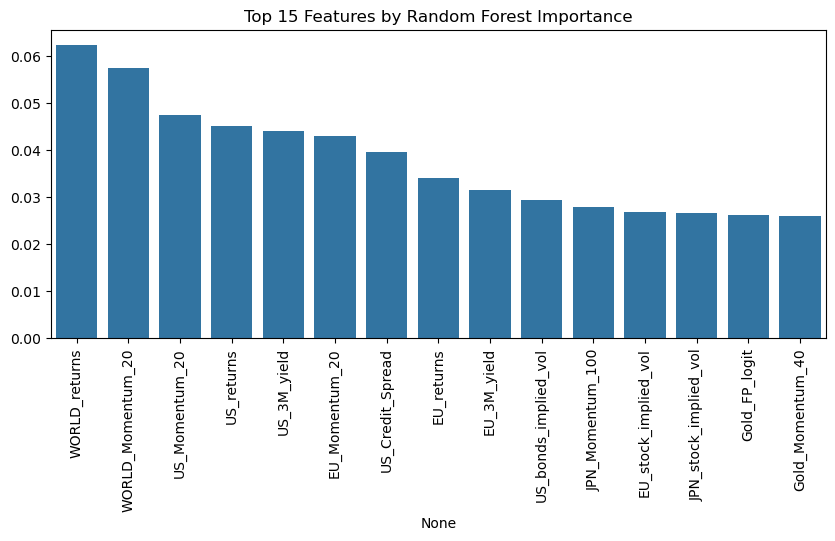

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Simple time-respecting split
n = len(X_train)
split = int(n * 0.8)
X_tr, X_val = X_train.iloc[:split], X_train.iloc[split:]
y_tr, y_val = y_train.iloc[:split], y_train.iloc[split:]

# Median imputation for simplicity
X_tr = X_tr.fillna(X_tr.median())
X_val = X_val.fillna(X_tr.median())

rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)

importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,4))
sns.barplot(x=importances.index[:15], y=importances.values[:15])
plt.xticks(rotation=90)
plt.title("Top 15 Features by Random Forest Importance")
plt.show()